# NYC DCP Historical Liquidation Project Sprint 2 Work

## TOC:
- [Setup](#first-bullet)
- [Group data NYC](#second-bullet)
- [Assigning categories based on `Budget Code` and `Contract Purpose](#third-bullet)
- [## Merge Checkbook NYC onto CPDB geometries](#fourth-bullet)

## Setup <a class="anchor" id="first-bullet"></a>

In [2]:
import pandas as pd
import numpy as np
import re
import datetime
import time
import geopandas as gpd
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import ticker
import seaborn as sns
import os
import time
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [4]:
# reading in data

# --- checkbook nyc data
file_names = [
    '../data/checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_0.csv', 
    '../data/checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_1.csv',
    '../data/checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_2.csv',
    '../data/checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_3.csv'
]
df0 = pd.read_csv(file_names[0])
df1 = pd.read_csv(file_names[1])
df2 = pd.read_csv(file_names[2])
df3 = pd.read_csv(file_names[3])
frames = [df0, df1, df2, df3]
checkbook = pd.concat(frames)

# --- cpdb geometries

path = "../data/cpdb/"
cpdb_file_list = os.listdir(path)
cpdb_file_list.remove('cpdb_projects.csv')
cpdb_file_list.remove('.DS_Store')


In [6]:
# merge cpdb data 
def merge_all_cpdb_geoms(path, file_list):
    """
    input: path and list of file names
    output: GeoDataFrame
    """
    file_list = sorted(file_list, key=lambda x: int(re.search(r'\d+$',x).group()), reverse=True)

    gdf_list = []
    for f in file_list:
        gdf = gpd.read_file(path + f)
        gdf_list.append(gdf)

    all_cpdb_geoms = pd.concat(gdf_list)
    # deal with duplicates
    all_cpdb_geoms.drop_duplicates(subset='maprojid', keep='first', inplace=True, ignore_index=True)
    return all_cpdb_geoms

# joining all of Checkbook NYC onto all cpdb
def join_checkbook_geoms(df, cpdb_geoms):
    """
    input:
    df -> dataframe to be left joined onto, in this case checkbook nyc
    cpdb_geoms -> geodataframe to join onto df, contains all shape files 2017-2023
    output:
    gdf -> geodataframe of cpdb geometries left joined onto checkbook nyc
    """
    merged = df.merge(cpdb_geoms, how='left', left_on='FMS ID', right_on='maprojid', indicator=True) # left join so we can easily count how many projects did not map to a geometry
    ### may need to uncomment this later because it might break something 
    #merged.drop('Unnamed: 0', axis=1, inplace=True)
    gdf = gpd.GeoDataFrame(merged, geometry='geometry')
    return gdf

In [7]:
# merge cpdb geometries
all_cpdb = merge_all_cpdb_geoms(path, cpdb_file_list)

In [8]:
#  data cleaning 

# --- checkbook nyc data cleaning 
checkbook = checkbook[checkbook['Check Amount']<99000000] # exclude checks over 99 mil
checkbook = checkbook[checkbook['Check Amount']>=0] # exclude negative checks, include 0 checks
checkbook['FMS ID'] = checkbook['Capital Project'].str.replace(r'\s*\d+$','') # new column for joining on CPDB

# ^^^^ is this correct??? lots of rows don't have spaces at the end, and when I look up the capital project IDs / FMS IDs in the capital
# planning explorer a lot of these don't show up. maybe they just don't have geometries... 

/var/folders/7p/9414x_x93rvb4p6kc2ny_wl00000gn/T/ipykernel_13917/3708058918.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  checkbook['FMS ID'] = checkbook['Capital Project'].str.replace(r'\s*\d+$','') # new column for joining on CPDB


In [9]:
checkbook['FMS ID'].nunique()

16687

## Group Checkbook NYC <a class="anchor" id="second-bullet"></a>

In [10]:
# --- groupby 
temp_cols_for_grouping = ['FMS ID']
temp_cols_for_limiting = temp_cols_for_grouping + ['Contract Purpose', 'Agency', 'Budget Code', 'Check Amount']

df_limited_cols = checkbook.loc[:, temp_cols_for_limiting]

def fn_join_vals(x):
    return ';'.join([y for y in list(x) if pd.notna(y)])

agg_dict = {'Check Amount':'sum', 
'Contract Purpose': fn_join_vals,
'Budget Code': fn_join_vals,
'Agency': fn_join_vals}

df = df_limited_cols.groupby(temp_cols_for_grouping, as_index=False).agg(agg_dict)
df

,FMS ID,Check Amount,Contract Purpose,Budget Code,Agency
0,002FINC01,53383178.89,,DUMY (INITIAL COI AUTHORIZATION; FY 2004C);DUM...,Department of Citywide Administrative Services...
1,035L22DITFI,276110.00,Digital Imaging Equipment;Digital Imaging Equi...,"TFIE (NYRL, LIBRARY SERVICES CENTER (31-11 THO...",New York Research Libraries;New York Research ...
2,035L22DRSSCP,1998283.01,Dell/EMC Equipment for DRSS,DRS8 (NYPL: SYSTEMWIDE: UPGRADE & EXPAND DIGIT),New York Research Libraries
3,035LR20PCPR,307000.00,"PC, Laptop, Printer Refresh;PC, Laptop, Printe...","LRPC (NYPL, PURCHASE NETWORKED COMPUTER SYSTE)...",New York Research Libraries;New York Research ...
4,035LRCA12TEK,154787.43,Enterprise Storage System;Enterprise Storage S...,EBUS (NYPL SYSTEMWIDE: PURCHASE ENTERPRISE BAK...,New York Research Libraries;New York Research ...
...,...,...,...,...,...
16682,998SIMISC,1251580.56,CP66058 SIR ST. GEORGE TRACK AND SIGNAL REPLAC...,TRT3 (SIRTOA (STATEN ISLAND RAPID TRANSIT OPER...,Transit Authority;TRANSIT AUTHORITY - CAPITAL;...
16683,998SIMTABUS,3500000.00,BUS REPLACEMENT;BUS REPLACEMENT ON BEHALF OF N...,RBUS (NYCT: PURCHASE BY MTA OF 745 HYBRD ELECT...,TRANSIT AUTHORITY - CAPITAL;TRANSIT AUTHORITY ...
16684,998SISEC,250000.00,"BUS PURCHASE,STATION REPAIRS, SECURITY CAMERAS",,TRANSIT AUTHORITY - CAPITAL
16685,998SITRACK,11948020.59,2017 MAINLINE TRACK REPLACEMENT AT VARIOUS LOC...,SUB1 (MTA /NYCT: CREATE NEW ELECTICAL POWER SU...,Transit Authority;Transit Authority;Transit Au...


In [11]:
#df.to_csv('checkbook_projects.csv')

In [12]:
df.sample(5)

,FMS ID,Check Amount,Contract Purpose,Budget Code,Agency
15592,850SECBHLN2,1748782.77,RECON OF CATCH BASIN AT VARIOUS LOCATION IN M...,F34Q (ACT STM SWR ZIEREGA AV BX CONST OF STM S...,Department of Environmental Protection;Departm...
16249,856PW77GLDRF,4018682.91,Roof Reconstruction at 100 Gold Street;Roof Re...,"RFGL (100 GOLD ST, MN: RECON ROOF INCL REPLACI...",Department of Citywide Administrative Services...
8947,81924202205,256898.92,24202205 NCB LOTHROP FIRE ALARM REPLACEMENT;24...,JE17 (HHC: NORTH CENTRAL BRONX (3424 KOSSUTH A...,Health and Hospitals Corporation;Health and Ho...
12875,846P-6GRST9A,50000.00,PLANTING NEW/REPLACEMENT STREET TREES&FLOWERS ...,,Department of Parks and Recreation
5048,057F212VASWI,478566.11,"PREV MAINT,REPAIR,UPGRADE, SYST INTEGR FOR CO...",VASW (FDNY 911 VOICE ALARM ROUTERS AND SWITCHE...,Fire Department;Fire Department;Fire Departmen...


## Assigning categories based on `Budget Code` and `Contract Purpose`<a class="anchor" id="third-bullet"></a>


In [13]:
# --- create bc_category and cp_category columns
df['bc_category'] = None
df['cp_category'] = None

In [14]:
# --- establish sql db and session
db_url = 'sqlite:///checkbook.db'
engine = create_engine(db_url)
Session = sessionmaker(bind=engine)
session = Session()

table_name = 'capital_projects'
df.to_sql(table_name, engine, if_exists='replace', index=False)

16687

In [15]:
# SQL Query for ITT, Vehicles, and Equipment category

query_itt_vehicles_equipment = """
UPDATE capital_projects SET bc_category = 'ITT, Vehicles, and Equipment'
WHERE (
upper([Budget Code]) LIKE '%VEHICLE%'
OR upper([Budget Code]) LIKE '%AMBULANCE%'
OR upper([Budget Code]) LIKE '%BUSES%'
OR upper([Budget Code]) LIKE '%TRUCK%'
OR upper([Budget Code]) LIKE '%TRAILER%'
OR upper([Budget Code]) LIKE '%VANS%'

OR upper([Budget Code]) LIKE '%EQUIPMENT%'
OR upper([Budget Code]) LIKE '%CRANE%'
OR upper([Budget Code]) LIKE '%FURNITURE%'
OR upper([Budget Code]) LIKE '%PORTABLE%'

OR upper([Budget Code]) LIKE '% IT %'
OR upper([Budget Code]) LIKE '%AUDIO%'
OR upper([Budget Code]) LIKE '%CAMERA%'
OR upper([Budget Code]) LIKE '%COMPUTERS%'
OR upper([Budget Code]) LIKE '%DATA%'
OR upper([Budget Code]) LIKE '%DOITT%'
OR upper([Budget Code]) LIKE '%FISA%'
OR upper([Budget Code]) LIKE '%GIS%'
OR upper([Budget Code]) LIKE '%HARDWARE%'
OR upper([Budget Code]) LIKE '%MAINFRAME%'
OR upper([Budget Code]) LIKE '%MOBILE%'
OR upper([Budget Code]) LIKE '%PHONE%'
OR upper([Budget Code]) LIKE '%PRINTER%'
OR upper([Budget Code]) LIKE '%SERVER%'
OR upper([Budget Code]) LIKE '%SOFTWARE%'
OR upper([Budget Code]) LIKE '%RADIO %'
OR upper([Budget Code]) LIKE '%RADIOS%'
OR upper([Budget Code]) LIKE '%VIDEO%'
OR upper([Budget Code]) LIKE '%VOIP%'
OR upper([Budget Code]) LIKE '%WIFI%'

-- New trigger words
OR upper([Budget Code]) LIKE '%A/V%'
OR upper([Budget Code]) LIKE '% AV %'
OR upper([Budget Code]) LIKE '%ACCESS%UPGRADE%'
OR upper([Budget Code]) LIKE '%AIMS%'
OR upper([Budget Code]) LIKE '%ANALYTICS%'
OR upper([Budget Code]) LIKE '%ANTENA%'
OR upper([Budget Code]) LIKE '%APPARATUS%'
OR upper([Budget Code]) LIKE '%ARREST%PROCESSING%'
OR upper([Budget Code]) LIKE '%ARRESTOR%'
OR upper([Budget Code]) LIKE '%ASSET%TRACKER%'
OR upper([Budget Code]) LIKE '%AUTOMATIC%'
OR upper([Budget Code]) LIKE '%AUTOMATION%'
OR upper([Budget Code]) LIKE '%BARGE%'
OR upper([Budget Code]) LIKE '%BED%'
OR upper([Budget Code]) LIKE '% BMS %'
OR upper([Budget Code]) LIKE '%BOATS%'
OR upper([Budget Code]) LIKE '% BUS %'
OR upper([Budget Code]) LIKE '%BUS'
OR upper([Budget Code]) LIKE '%CART%'
OR upper([Budget Code]) LIKE '%CATHETERIZATION%'
OR upper([Budget Code]) LIKE '%CCTV%'
OR upper([Budget Code]) LIKE '%CHECKBOOK%NYC%'
OR upper([Budget Code]) LIKE '%CISCO%'
OR upper([Budget Code]) LIKE '%CITYTIME%'
OR upper([Budget Code]) LIKE '%COMMUNICATIONS%'
OR upper([Budget Code]) LIKE '%COMMUNICATION%EQUI%'
OR upper([Budget Code]) LIKE '%COMPRESSOR%'
OR upper([Budget Code]) LIKE '%COMPUTER%EQUIP%'
OR upper([Budget Code]) LIKE '%COMPUTER%REPL%'
OR upper([Budget Code]) LIKE '%COMPUTER%SYS%'
OR upper([Budget Code]) LIKE '%COMP%UPGRADE%'
OR upper([Budget Code]) LIKE '%COMPUTERIZED%'
OR upper([Budget Code]) LIKE '%COPIER%'
OR upper([Budget Code]) LIKE '%CT%SCAN%'
OR upper([Budget Code]) LIKE '%CURTAIN%'
OR upper([Budget Code]) LIKE '%CYTOMETER%'
OR upper([Budget Code]) LIKE '%DCTV%'
OR upper([Budget Code]) LIKE '%DESKTOP%'
OR upper([Budget Code]) LIKE '%DEVICE%'
OR upper([Budget Code]) LIKE '%DIGITAL%'
OR upper([Budget Code]) LIKE '%DISINFECTION%'
OR upper([Budget Code]) LIKE '%E-TICKET%'
OR upper([Budget Code]) LIKE '%ECTP%'
OR upper([Budget Code]) LIKE '%ELECTRONIC%'
OR upper([Budget Code]) LIKE '%EMAIL%'
OR upper([Budget Code]) LIKE '%ENCRYPT%'
OR upper([Budget Code]) LIKE '%ENGINE%'
OR upper([Budget Code]) LIKE '%ENTERPRISE%SOLUTIONS%'
OR upper([Budget Code]) LIKE '%EQ%PURCHASE%'
OR upper([Budget Code]) LIKE '%EQUIP%'
OR upper([Budget Code]) LIKE '%FERRY%BO%'
OR upper([Budget Code]) LIKE '%FFE%'
OR upper([Budget Code]) LIKE '%FILM%'
OR upper([Budget Code]) LIKE '%FIREBOAT%'
OR upper([Budget Code]) LIKE '%FLAT%BED%'
OR upper([Budget Code]) LIKE '%FLEET%'
OR upper([Budget Code]) LIKE '%FMS%'
OR upper([Budget Code]) LIKE '%FORKLIFT%'
OR upper([Budget Code]) LIKE '%GENERATOR%'
OR upper([Budget Code]) LIKE '%GPS%'
OR upper([Budget Code]) LIKE '%HDTV%'
OR upper([Budget Code]) LIKE '%HELICOPTER%'
OR upper([Budget Code]) LIKE '%HHS%ACC%'
OR upper([Budget Code]) LIKE '%INFO%MANAGE%'
OR upper([Budget Code]) LIKE '%INFO%SECURITY%'
OR upper([Budget Code]) LIKE '%INTERFACE%'
OR upper([Budget Code]) LIKE 'IT %'
OR upper([Budget Code]) LIKE '% IT'
OR upper([Budget Code]) LIKE '%IVR %'
OR upper([Budget Code]) LIKE '%KEYWORD%'
OR upper([Budget Code]) LIKE '%KITS%'
OR upper([Budget Code]) LIKE '%LADDER%'
OR upper([Budget Code]) LIKE '% LAN %'
OR upper([Budget Code]) LIKE '%LUNG%UNIT%'
OR upper([Budget Code]) LIKE '%MACHINE%'
OR upper([Budget Code]) LIKE '%MAMOGRAM%'
OR upper([Budget Code]) LIKE '%MANHOLE%COVER%'
OR upper([Budget Code]) LIKE '%MANHOLE%RING%'
OR upper([Budget Code]) LIKE '%MANOMETRY%'
OR upper([Budget Code]) LIKE '%MED%EQMT%'
OR upper([Budget Code]) LIKE '%MEDIA%UPGRADE%'
OR upper([Budget Code]) LIKE '%MICROFILM%'
OR upper([Budget Code]) LIKE '%MICROSCOPE%'
OR upper([Budget Code]) LIKE '%MICROSPECT%'
OR upper([Budget Code]) LIKE '%MINI%BUS%'
OR upper([Budget Code]) LIKE '%MINI%VAN%'
OR upper([Budget Code]) LIKE '%MOBILIZING%'
OR upper([Budget Code]) LIKE '%MONITOR%'
OR upper([Budget Code]) LIKE '%MOORING%UPGRADE%'
OR upper([Budget Code]) LIKE '%MOSAICS%'
OR upper([Budget Code]) LIKE '%MOVEABLE%'
OR upper([Budget Code]) LIKE '%MRI%'
OR upper([Budget Code]) LIKE '%NETWORK%'
OR upper([Budget Code]) LIKE '%NOVAS%'
OR upper([Budget Code]) LIKE '%NYCAPP%'
OR upper([Budget Code]) LIKE '%NYCAPS%'
OR upper([Budget Code]) LIKE '%NYCSERV%'
OR upper([Budget Code]) LIKE '%OAISIS%'
OR upper([Budget Code]) LIKE '%PAPERLESS%'
OR upper([Budget Code]) LIKE '%PASSENGER%VAN%'
OR upper([Budget Code]) LIKE '%PIANO%'
OR upper([Budget Code]) LIKE '%PORTAL%'
OR upper([Budget Code]) LIKE '%POWER%WASHER%'
OR upper([Budget Code]) LIKE '%PRINTING%'
OR upper([Budget Code]) LIKE '%PROJECTORS%'
OR upper([Budget Code]) LIKE '%PROJECTION%SYS%'
OR upper([Budget Code]) LIKE '%PROJECTION%SOUND%SYSTEM%'
OR upper([Budget Code]) LIKE '%PUMPERS%'
OR upper([Budget Code]) LIKE '%PURCHASE%'
OR upper([Budget Code]) LIKE '%REAL%TIME%INFO%'
OR upper([Budget Code]) LIKE '%REAL%TIME%SIGN%'
OR upper([Budget Code]) LIKE '%RECORDER%'
OR upper([Budget Code]) LIKE '%REFRIGERATOR%'
OR upper([Budget Code]) LIKE '%REPORTING%'
OR upper([Budget Code]) LIKE '%RESPONSE%BOAT%'
OR upper([Budget Code]) LIKE '% RIG %'
OR upper([Budget Code]) LIKE '%ROBOT%'
OR upper([Budget Code]) LIKE '%ROUTER%'
OR upper([Budget Code]) LIKE '%SATELLITE%'
OR upper([Budget Code]) LIKE '%SCANNER%'
OR upper([Budget Code]) LIKE '%SCANNING%'
OR upper([Budget Code]) LIKE '%SCHOOL%BUS%'
OR upper([Budget Code]) LIKE '%SELF%CHECK%'
OR upper([Budget Code]) LIKE '%SEQUENCER%'
OR upper([Budget Code]) LIKE '%SHUTTLE%'
OR upper([Budget Code]) LIKE '%SIMULATOR%'
OR upper([Budget Code]) LIKE '%SKID%STEER%'
OR upper([Budget Code]) LIKE '%SPECTROMETER%'
OR upper([Budget Code]) LIKE '%SPECTROPHMETER%'
OR upper([Budget Code]) LIKE '%SUBURBANS%'
OR upper([Budget Code]) LIKE '%SURVEILLANCE%'
OR upper([Budget Code]) LIKE '%SONOGRAM%'
OR upper([Budget Code]) LIKE '%SOUND%SYST%'
OR upper([Budget Code]) LIKE '%STREAMING%'
OR upper([Budget Code]) LIKE '%SWEEPER%'
OR upper([Budget Code]) LIKE '%SYSTEM%INTEGRATOR%'
OR upper([Budget Code]) LIKE '%SYSTEM%UPGRADE%'
OR upper([Budget Code]) LIKE '% TABLES%'
OR upper([Budget Code]) LIKE '% TECH%'
OR upper([Budget Code]) LIKE 'TECH%'
OR upper([Budget Code]) LIKE '%TELECOM%'
OR upper([Budget Code]) LIKE '%TELEMETRY%'
OR upper([Budget Code]) LIKE '%TOOLCAT%'
OR upper([Budget Code]) LIKE '%TRACTOR%'
OR upper([Budget Code]) LIKE '%TRAM%'
OR upper([Budget Code]) LIKE '%TRANSPORTATION%BUS%'
OR upper([Budget Code]) LIKE '%TROLLEY%'
OR upper([Budget Code]) LIKE '%ULTRASOUND%'
OR upper([Budget Code]) LIKE '%VAN'
OR upper([Budget Code]) LIKE '%VASCULAR%'
OR upper([Budget Code]) LIKE '%VENDING%'
OR upper([Budget Code]) LIKE '%VESSEL%'
OR upper([Budget Code]) LIKE '%VIRTUAL%'
OR upper([Budget Code]) LIKE '%VOICE%'
OR upper([Budget Code]) LIKE '%WAGON%'
OR upper([Budget Code]) LIKE '%WEB%PROXY%'
OR upper([Budget Code]) LIKE '%WEBSITE%'
OR upper([Budget Code]) LIKE '%WI-FI%'
OR upper([Budget Code]) LIKE '%WIRELESS%'
OR upper([Budget Code]) LIKE '%WIRETAP%'
OR upper([Budget Code]) LIKE '%WORK%STATION%'
OR upper([Budget Code]) LIKE '% X%RAY%'
OR upper([Budget Code]) LIKE '%ZAMBONI%'

-- Systems
OR upper([Budget Code]) LIKE '%ADDRESS%SYST%'
OR upper([Budget Code]) LIKE '%ADMIN%SYS%'
OR upper([Budget Code]) LIKE '%ASSET%SYS%'
OR upper([Budget Code]) LIKE '%ASSIGNMENT%SYST%'
OR upper([Budget Code]) LIKE '%ALARM%SYST%'
OR upper([Budget Code]) LIKE '%AUTOMATED%SYST%'
OR upper([Budget Code]) LIKE '%BILLING%SYST%'
OR upper([Budget Code]) LIKE '%BIOVAULT%SYST%'
OR upper([Budget Code]) LIKE '%COMMUNICATION%SYST%'
OR upper([Budget Code]) LIKE '%CRIME%SYST%'
OR upper([Budget Code]) LIKE '%ENROLLMENT%SYS%'
OR upper([Budget Code]) LIKE '%EQ %SYS%'
OR upper([Budget Code]) LIKE '%FAST%PASS%SYS%'
OR upper([Budget Code]) LIKE '%FILING%SYS%'
OR upper([Budget Code]) LIKE '%FIN% SYS%'
OR upper([Budget Code]) LIKE '%IMAGING%SYST%'
OR upper([Budget Code]) LIKE '%INFO%SYST%'
OR upper([Budget Code]) LIKE '%INGEST%SYST%'
OR upper([Budget Code]) LIKE '%INTELL%SYST%'
OR upper([Budget Code]) LIKE '%LAUNDRY%SYS%'
OR upper([Budget Code]) LIKE '%LICENSING%SYS%'
OR upper([Budget Code]) LIKE '%LOAD%SYS%'
OR upper([Budget Code]) LIKE '%MANAGEMENT%SYST%'
OR upper([Budget Code]) LIKE '%MEASUREMENT%SYST%'
OR upper([Budget Code]) LIKE '%MED%SYST%'
OR upper([Budget Code]) LIKE '%MEDIA%SYST%'
OR upper([Budget Code]) LIKE '%PRESERVATION%SYST%'
OR upper([Budget Code]) LIKE '%PREVENTION%SYST%'
OR upper([Budget Code]) LIKE '%PROCESSING%SYST%'
OR upper([Budget Code]) LIKE '%SECURITY%SYST%'
OR upper([Budget Code]) LIKE '%SYSTEMWIDE%SYST%'
OR upper([Budget Code]) LIKE '%TAX%SYST%'
OR upper([Budget Code]) LIKE '%TICKET%SYST%'
OR upper([Budget Code]) LIKE '%TRACKING%SYST%'
OR upper([Budget Code]) LIKE '%WORKFORCE%SYST%'
)
AND( upper([Budget Code]) NOT LIKE '%GARAGE%' );
"""

In [16]:
# SQL Query for Lump Sum category
query_lump_sum = """
UPDATE capital_projects SET bc_category = 'Lump Sum'
WHERE (
upper([Budget Code]) LIKE '%LUMP SUM%'
OR upper([Budget Code]) LIKE '% FUND%'
OR upper([Budget Code]) LIKE 'FUND%'
OR upper([Budget Code]) LIKE '%SURVEY%'
OR upper([Budget Code]) LIKE '%SUPERVISION%'
OR upper([Budget Code]) LIKE '%PROGRAM%'

--new
OR upper([Budget Code]) LIKE '%10%YEAR%PLAN%'
OR upper([Budget Code]) LIKE '%ACQUISITION%CITYWIDE%'
OR upper([Budget Code]) LIKE '%AGENCY%PROPOSED%PROJECT%'
OR upper([Budget Code]) LIKE '%AGREEMENT%'
OR upper([Budget Code]) LIKE '%APPLICATION%'
OR upper([Budget Code]) LIKE '%ASSESSMENT%'
OR upper([Budget Code]) LIKE '%ASSOC%'
OR upper([Budget Code]) LIKE '%AUDITOR%'
OR upper([Budget Code]) LIKE '%AVIATION%'
OR upper([Budget Code]) LIKE '%BIOSWALES%STORMWATER%'
OR upper([Budget Code]) LIKE '%BPL%INFRASTRUCTURE%RECONSTRUCTION%'
OR upper([Budget Code]) LIKE '%BUNDLE%PROJECTS%'
OR upper([Budget Code]) LIKE '%CAPITAL%COMP%'
OR upper([Budget Code]) LIKE '%CAMPAIGN%'
OR upper([Budget Code]) LIKE '%CALTHOLIC%MANAGE%'
OR upper([Budget Code]) LIKE '%CITY%WIDE%ACQUISITION%'
OR upper([Budget Code]) LIKE '%CITY%WIDE%MANAGEMENT%'
OR upper([Budget Code]) LIKE '%CITY%WIDE%MEASURES%'
OR upper([Budget Code]) LIKE '%CITY%WIDE%SECURITY%'
OR upper([Budget Code]) LIKE '%COACH%'
OR upper([Budget Code]) LIKE '%COALITION%'
OR upper([Budget Code]) LIKE '%COMB%'
OR upper([Budget Code]) LIKE '%COMMITTEE%'
OR upper([Budget Code]) LIKE '%COMPLIANCE%'
OR upper([Budget Code]) LIKE '%COMPUTER%PROG%'
OR upper([Budget Code]) LIKE '%CONTRACT%'
OR upper([Budget Code]) LIKE '%CONSERVATION%'
OR upper([Budget Code]) LIKE '%CONSULTANT%'
OR upper([Budget Code]) LIKE '%CONTRACTS%'
OR upper([Budget Code]) LIKE '%COOKING%PROJECT%'
OR upper([Budget Code]) LIKE '%COOPERATIVE%'
OR upper([Budget Code]) LIKE '%CORP%'
OR upper([Budget Code]) LIKE '%COUNCIL%'
OR upper([Budget Code]) LIKE '%DISTRIBUTION%FY%'
OR upper([Budget Code]) LIKE '%ELLA%FY%'
OR upper([Budget Code]) LIKE '%EMERGENCY%CONT%'
OR upper([Budget Code]) LIKE '%EMERGENCY%SAFETY%SYSTEMS%'
OR upper([Budget Code]) LIKE '%EXAMINATION%'
OR upper([Budget Code]) LIKE '%FERRY%PROJECTS%'
OR upper([Budget Code]) LIKE '%FUND'
OR upper([Budget Code]) LIKE '%GENERAL%'
OR upper([Budget Code]) LIKE '%HUD %'
OR upper([Budget Code]) LIKE '%HOLD %'
OR upper([Budget Code]) LIKE '% HOLD%'
OR upper([Budget Code]) LIKE '%IFA %'
OR upper([Budget Code]) LIKE '%IMPACT%STATEMENT%'
OR upper([Budget Code]) LIKE '%IMPROVEMENT%CITYWIDE%'
OR upper([Budget Code]) LIKE '% INC%'
OR upper([Budget Code]) LIKE '%INITIATIVE%'
OR upper([Budget Code]) LIKE '%INTITIATIVE%'
OR upper([Budget Code]) LIKE '%INSPCTN%'
OR upper([Budget Code]) LIKE '%INSPECTN%'
OR upper([Budget Code]) LIKE '%INSPECTION%'
OR upper([Budget Code]) LIKE '%INVESTIG%'
OR upper([Budget Code]) LIKE '%JOB%ORDER%CONTRACT%'
OR upper([Budget Code]) LIKE '% LLC%'
OR upper([Budget Code]) LIKE '%LUMP%'
OR upper([Budget Code]) LIKE '%MANAGEMENT%'
OR upper([Budget Code]) LIKE '%MAINTENANCE%'
OR upper([Budget Code]) LIKE '%MASTER%PLAN%'
OR upper([Budget Code]) LIKE '%MGNT%SVCS%'
OR upper([Budget Code]) LIKE '%MGNT%SVCES%'
OR upper([Budget Code]) LIKE '%MISC %'
OR upper([Budget Code]) LIKE '%MISC. %'
OR upper([Budget Code]) LIKE '%MISCELANNOUES%'
OR upper([Budget Code]) LIKE '%MITIGATION%PGM%'
OR upper([Budget Code]) LIKE '%MITIGATION%PROGRAM%'
OR upper([Budget Code]) LIKE '%MONITORING%'
OR upper([Budget Code]) LIKE '%NATIONAL%ASSOC%'
OR upper([Budget Code]) LIKE '%NEW%NEED%'
OR upper([Budget Code]) LIKE '%OPPORTUNIT%'
OR upper([Budget Code]) LIKE '%ORGANIZATION%'
OR upper([Budget Code]) LIKE '%OVERSIGHT%'
OR upper([Budget Code]) LIKE '%PARTNERSHIP%'
OR upper([Budget Code]) LIKE '%PED%SAFETY%'
OR upper([Budget Code]) LIKE '%PEDESTRIAN%SAFETY%'
OR upper([Budget Code]) LIKE '%PEDESTRIAN%SYS%'
OR upper([Budget Code]) LIKE '%PILOT%'
OR upper([Budget Code]) LIKE '%PLANNED%PARENTHOOD%OF%NYC'
OR upper([Budget Code]) LIKE '%PRIORITY%GRID%'
OR upper([Budget Code]) LIKE '%PROCUREMENT%'
OR upper([Budget Code]) LIKE '%PROFESSIONAL%SERVICE%'
OR upper([Budget Code]) LIKE '%PROJECT%RENEWAL'
OR upper([Budget Code]) LIKE '%PROG%'
OR upper([Budget Code]) LIKE '%PROTECTION%CITYWIDE%'
OR upper([Budget Code]) LIKE '%REIMBURSEMENT%'
OR upper([Budget Code]) LIKE '%RESILIENCY%MEASURES%'
OR upper([Budget Code]) LIKE '%RESOURCES%'
OR upper([Budget Code]) LIKE '%REVITAL%PROJECT%'
OR upper([Budget Code]) LIKE '%SAFE%COMMUNIT%'
OR upper([Budget Code]) LIKE '%SAFE%ROUTE%SCHOOL%'
OR upper([Budget Code]) LIKE '%SAFE%ROUTE%TO %'
OR upper([Budget Code]) LIKE '%SAFETY%IMPROVEMENT%'
OR upper([Budget Code]) LIKE '%SAFETY%PROJECT%'
OR upper([Budget Code]) LIKE '%SAMPLING%'
OR upper([Budget Code]) LIKE 'SCA%'
OR upper([Budget Code]) LIKE '%SE%&%WM%'
OR upper([Budget Code]) LIKE '%SEEDING%'
OR upper([Budget Code]) LIKE '%SERVICE%'
OR upper([Budget Code]) LIKE '%SERVICE%AGREEMENT%'
OR upper([Budget Code]) LIKE '%SEWER%WATER%'
OR upper([Budget Code]) LIKE '%SEWER%WM%'
OR upper([Budget Code]) LIKE '%SOCIETY%'
OR upper([Budget Code]) LIKE '%STAFF%'
OR upper([Budget Code]) LIKE '%STORM%WM%'
OR upper([Budget Code]) LIKE '%STORM%WATER%MANAGEMENT%'
OR upper([Budget Code]) LIKE '%STORM%WATER%MGMT%'
OR upper([Budget Code]) LIKE '%STRATEGIC%PLAN%'
OR upper([Budget Code]) LIKE '%STUDIES%'
OR upper([Budget Code]) LIKE '%SUPPORT%'
OR upper([Budget Code]) LIKE '%SURPLUS%'
OR upper([Budget Code]) LIKE '%SWER%WM%'
OR upper([Budget Code]) LIKE '%SWR%WM%'
OR upper([Budget Code]) LIKE '%SWR%W/M%'
OR upper([Budget Code]) LIKE '%SYSTEMWIDE%RENO%NEW%EXPAN%'
OR upper([Budget Code]) LIKE '%TASK%ORDER%'
OR upper([Budget Code]) LIKE '%TEN%YEAR%PLAN%'
OR upper([Budget Code]) LIKE '%TESTING%'
OR upper([Budget Code]) LIKE '%TORTS%'
OR upper([Budget Code]) LIKE '%TREES%'	
OR upper([Budget Code]) LIKE '%ULURP%'
OR upper([Budget Code]) LIKE '%VARIOUS%LOCATIONS%'
OR upper([Budget Code]) LIKE '%VARIOUS%WORK%'
OR upper([Budget Code]) LIKE '%VISION%ZERO%'
OR upper([Budget Code]) LIKE '%VOLUNTEERS%'
OR upper([Budget Code]) LIKE '%W/M%SEWER%'
OR upper([Budget Code]) LIKE '%W/M%SWR%'
OR upper([Budget Code]) LIKE '%WATER%MAIN%SEWER%'
OR upper([Budget Code]) LIKE '%WM%SEWER%'
OR upper([Budget Code]) LIKE '%WM%SWR%'

)
AND( upper([Budget Code]) NOT LIKE '%SPACE%')
AND( upper([Budget Code]) NOT LIKE '%RESTOR%' )
AND bc_category IS NULL;
"""

In [17]:
# SQL Query for Fixed Asset categorization

query_fixed_asset = """
UPDATE capital_projects SET bc_category = 'Fixed Asset'
WHERE (
upper([Budget Code]) LIKE '%AUDITORIUM%'
OR upper([Budget Code]) LIKE '%BASIN%'
OR upper([Budget Code]) LIKE '%BATHROOM%'
OR upper([Budget Code]) LIKE '%BOILER%'
OR upper([Budget Code]) LIKE '%BORING%'
OR upper([Budget Code]) LIKE '%BLVD%'
OR upper([Budget Code]) LIKE '%BRIDGE%'
OR upper([Budget Code]) LIKE '%BUILDING%'
OR upper([Budget Code]) LIKE '%BULKHEAD%'
OR upper([Budget Code]) LIKE '%CAFETERIA%'
OR upper([Budget Code]) LIKE '%CANAL%'
OR upper([Budget Code]) LIKE '%CEILING%'
OR upper([Budget Code]) LIKE '%CENTER%'
OR upper([Budget Code]) LIKE '%CLIMATE%'
OR upper([Budget Code]) LIKE '%CONSTRUCTION%'
OR upper([Budget Code]) LIKE '%COOLING%'
OR upper([Budget Code]) LIKE '%CULVERT%'
OR upper([Budget Code]) LIKE '%DAY CARE%'
OR upper([Budget Code]) LIKE '%DEPOT%'
OR upper([Budget Code]) LIKE '%ELECTRICAL%'
OR upper([Budget Code]) LIKE '%ELEVATOR%'
OR upper([Budget Code]) LIKE '%ESCALATOR%'
OR upper([Budget Code]) LIKE '%EXTERIOR%'
OR upper([Budget Code]) LIKE '%FACILITY%'
OR upper([Budget Code]) LIKE '%FENC%'
OR upper([Budget Code]) LIKE '%FIELD%'
OR upper([Budget Code]) LIKE '%FIXTURE%'
OR upper([Budget Code]) LIKE '%FLOOR%'
OR upper([Budget Code]) LIKE '%GARAGE%'
OR upper([Budget Code]) LIKE '%GARDEN%'
OR upper([Budget Code]) LIKE '%GREENWAY%'
OR upper([Budget Code]) LIKE '%GYM%'
OR upper([Budget Code]) LIKE '%HALL%'
OR upper([Budget Code]) LIKE '%HEATING%'
OR upper([Budget Code]) LIKE '%HOSPITAL%'
OR upper([Budget Code]) LIKE '%HOUSE%'
OR upper([Budget Code]) LIKE '%HVAC%'
OR upper([Budget Code]) LIKE '%INTERIOR%'
OR upper([Budget Code]) LIKE '%KITCHEN%'
OR upper([Budget Code]) LIKE '%LAB%'
OR upper([Budget Code]) LIKE '%LANDING%'
OR upper([Budget Code]) LIKE '%LIBRARY%'
OR upper([Budget Code]) LIKE '%LIGHTING%'
OR upper([Budget Code]) LIKE '%MASONRY%'
OR upper([Budget Code]) LIKE '%MILLING%'
OR upper([Budget Code]) LIKE '%MTS%'
OR upper([Budget Code]) LIKE '%MUSEUM%'
OR upper([Budget Code]) LIKE '%PARAPET%'
OR upper([Budget Code]) LIKE '%PARK%'
OR upper([Budget Code]) LIKE '%PIER%'
OR upper([Budget Code]) LIKE '%PIPE%'
OR upper([Budget Code]) LIKE '%PIPING%'
OR upper([Budget Code]) LIKE '%PLANT%'
OR upper([Budget Code]) LIKE '%PLAYGROUND%'
OR upper([Budget Code]) LIKE '%PLAZA%'
OR upper([Budget Code]) LIKE '%POOL%'
OR upper([Budget Code]) LIKE '%RAMP%'
OR upper([Budget Code]) LIKE '%RECON%'
OR upper([Budget Code]) LIKE '%REHAB%'
OR upper([Budget Code]) LIKE '%RENOVAT%'
OR upper([Budget Code]) LIKE '%REPLACE%'
OR upper([Budget Code]) LIKE '%RESTORATION%'
OR upper([Budget Code]) LIKE '%ROOF%'
OR upper([Budget Code]) LIKE '%ROOM%'
OR upper([Budget Code]) LIKE '%SEWER%'
OR upper([Budget Code]) LIKE '%SHELTER%'
OR upper([Budget Code]) LIKE '%SIDEWALK%'
OR upper([Budget Code]) LIKE '%SITE ACQ%'
OR upper([Budget Code]) LIKE '%SPRAY%BOOTH%'
OR upper([Budget Code]) LIKE '%STADIUM%'
OR upper([Budget Code]) LIKE '%STATION%'
OR upper([Budget Code]) LIKE '%STREET%'
OR upper([Budget Code]) LIKE '%TERMINAL%'
OR upper([Budget Code]) LIKE '%THEATER%'
OR upper([Budget Code]) LIKE '%TOILET%'
OR upper([Budget Code]) LIKE '%TUNNEL%'
OR upper([Budget Code]) LIKE '%VENTILATION%'
OR upper([Budget Code]) LIKE '%WASTE%'
OR upper([Budget Code]) LIKE '%WINDOW%'
OR upper([Budget Code]) LIKE '%WPC%'
OR upper([Budget Code]) LIKE '%WWTP%'

--new
OR upper([Budget Code]) LIKE '%A/C%'
OR upper([Budget Code]) LIKE '%ACQ%'
OR upper([Budget Code]) LIKE '%ACQUISITION%'
OR upper([Budget Code]) LIKE '%AERATION%'
OR upper([Budget Code]) LIKE '%ADA%'
OR upper([Budget Code]) LIKE '%ADDITION%'
OR upper([Budget Code]) LIKE '%AIR%BOX%'
OR upper([Budget Code]) LIKE '%AIR%CON%'
OR upper([Budget Code]) LIKE '%ALARM%BOX%'
OR upper([Budget Code]) LIKE '%ANNEX%'
OR upper([Budget Code]) LIKE '%ARENA%'
OR upper([Budget Code]) LIKE '%ART%'
OR upper([Budget Code]) LIKE '%ASBESTOS%'
OR upper([Budget Code]) LIKE '%ASPHALT%'
OR upper([Budget Code]) LIKE '%ATRIUM%'
OR upper([Budget Code]) LIKE '%ATC%'
OR upper([Budget Code]) LIKE '%AQUARIUM%'
OR upper([Budget Code]) LIKE '%BACKFLOW%SYS%'
OR upper([Budget Code]) LIKE '%BARRIER%'
OR upper([Budget Code]) LIKE '%BOAT%LAUNCH%'
OR upper([Budget Code]) LIKE '%BIKEWAY%'
OR upper([Budget Code]) LIKE '%BIN%'
OR upper([Budget Code]) LIKE '%BIOSWALE%'
OR upper([Budget Code]) LIKE '%BLDG%'
OR upper([Budget Code]) LIKE '%BLDG%ACQ%'
OR upper([Budget Code]) LIKE '%BLUEBELT%'
OR upper([Budget Code]) LIKE '%BOARDWALK%'
OR upper([Budget Code]) LIKE '%BURNER%'
OR upper([Budget Code]) LIKE '%CABLING%'
OR upper([Budget Code]) LIKE '%CALL%BOX%'
OR upper([Budget Code]) LIKE '%CAMPUS%'
OR upper([Budget Code]) LIKE '%CAR%PORT%'
OR upper([Budget Code]) LIKE '%CATWALK%'
OR upper([Budget Code]) LIKE '%CEMETERY%'
OR upper([Budget Code]) LIKE '%CHAMBER%'
OR upper([Budget Code]) LIKE '%CHILLER%'
OR upper([Budget Code]) LIKE '%CLINIC%'
OR upper([Budget Code]) LIKE '%COMFORT%ST%'
OR upper([Budget Code]) LIKE '%COMPACTOR%'
OR upper([Budget Code]) LIKE '%COMPUTER%LAB%'
OR upper([Budget Code]) LIKE '%COMPUTER%ROOM%'
OR upper([Budget Code]) LIKE '%CONDUIT%'
OR upper([Budget Code]) LIKE '%CONSOLIDATION%'
OR upper([Budget Code]) LIKE '%CONSTRUCT%'
OR upper([Budget Code]) LIKE '%CONVERSION%'
OR upper([Budget Code]) LIKE '%CORRIDOR%'
OR upper([Budget Code]) LIKE '%COURT%'
OR upper([Budget Code]) LIKE '% CTS %'
OR upper([Budget Code]) LIKE 'CTS %'
OR upper([Budget Code]) LIKE '% CTS'
OR upper([Budget Code]) LIKE '%CSO%'
OR upper([Budget Code]) LIKE '%DAM%'
OR upper([Budget Code]) LIKE '%DEMOLITION%'
OR upper([Budget Code]) LIKE '%DEVELOPMENT%'
OR upper([Budget Code]) LIKE '%DIGESTER%'
OR upper([Budget Code]) LIKE '%DIMMER%SYST%'
OR upper([Budget Code]) LIKE '%DOCK%'
OR upper([Budget Code]) LIKE '%DOG%RUN%'
OR upper([Budget Code]) LIKE '%DOOR%'
OR upper([Budget Code]) LIKE '%DORM%'
OR upper([Budget Code]) LIKE '%DUCT%'
OR upper([Budget Code]) LIKE '%EE%UPGRADE%'
OR upper([Budget Code]) LIKE '%EJECTOR%'
OR upper([Budget Code]) LIKE '%ELECTRIC%SYS%'
OR upper([Budget Code]) LIKE '%ELEC%UPGRADE%'
OR upper([Budget Code]) LIKE '%ENCLOS%'
OR upper([Budget Code]) LIKE '%ENERGY%UPGRADE%'
OR upper([Budget Code]) LIKE '%ENTRANCE%'
OR upper([Budget Code]) LIKE '%ENTRY'
OR upper([Budget Code]) LIKE '%ESPLANADE%'
OR upper([Budget Code]) LIKE '%EXHAUST%SYSTEM%'
OR upper([Budget Code]) LIKE '%EXHIBIT%'
OR upper([Budget Code]) LIKE '%EXPANSION%'
OR upper([Budget Code]) LIKE '%EXTENSION%'
OR upper([Budget Code]) LIKE '%FACADE%'
OR upper([Budget Code]) LIKE '%FACILIT%'
OR upper([Budget Code]) LIKE '%FIRE%ALAR%'
OR upper([Budget Code]) LIKE '%FIRE%SAFETY%'
OR upper([Budget Code]) LIKE '%FIRE%SYSTEM%'
OR upper([Budget Code]) LIKE '%FIRE%UPGRADE%'
OR upper([Budget Code]) LIKE '%FLAG%'
OR upper([Budget Code]) LIKE '%FOUNTAIN%'
OR upper([Budget Code]) LIKE '%GALLERY%'
OR upper([Budget Code]) LIKE '%GAS%'
OR upper([Budget Code]) LIKE '%GATE%'
OR upper([Budget Code]) LIKE '%GOLF%COURSE%'
OR upper([Budget Code]) LIKE '%GOVERNORS%ISLAND%'
OR upper([Budget Code]) LIKE '% GRAT%'
OR upper([Budget Code]) LIKE '%GUARDS%'
OR upper([Budget Code]) LIKE '%HEAT%'
OR upper([Budget Code]) LIKE '%HIGH%LINE%'
OR upper([Budget Code]) LIKE '%HOT%WATER%'
OR upper([Budget Code]) LIKE '%INFRASTRUCTURE%'
OR upper([Budget Code]) LIKE '%INSTALLATION%'
OR upper([Budget Code]) LIKE '%INTERCONNECTION%'
OR upper([Budget Code]) LIKE '%IRRIGATION%'
OR upper([Budget Code]) LIKE '%LAMP%'
OR upper([Budget Code]) LIKE '%LAWNS%'
OR upper([Budget Code]) LIKE '%LEASE%RENEW%'
OR upper([Budget Code]) LIKE '%LIGHTS%'
OR upper([Budget Code]) LIKE '%LIGHTPOLE%'
OR upper([Budget Code]) LIKE '%LOCAL%LAW%11%'
OR upper([Budget Code]) LIKE '%LOUNGE%'
OR upper([Budget Code]) LIKE '%MARINA%'
OR upper([Budget Code]) LIKE '%MEDIAN%'
OR upper([Budget Code]) LIKE '%MICROFILTRATION%'
OR upper([Budget Code]) LIKE '%MODERNIZATION%'
OR upper([Budget Code]) LIKE '% MOVE %'
OR upper([Budget Code]) LIKE '%NEW%BRANCH%'
OR upper([Budget Code]) LIKE 'NDF%'
OR upper([Budget Code]) LIKE '%OBSERVATORY%'
OR upper([Budget Code]) LIKE '%OFFICES%'
OR upper([Budget Code]) LIKE '%OUTDOOR%SPACE%'
OR upper([Budget Code]) LIKE '%OUTFITTIN%'
OR upper([Budget Code]) LIKE '%OUT-FITTIN%'
OR upper([Budget Code]) LIKE '%OVERPASS%'
OR upper([Budget Code]) LIKE '%PASSIVE%LANDSCAPE%'
OR upper([Budget Code]) LIKE '%PATH%'
OR upper([Budget Code]) LIKE '%PAVEMENT%'
OR upper([Budget Code]) LIKE '% PEN %'
OR upper([Budget Code]) LIKE '%PEDESTALS%'
OR upper([Budget Code]) LIKE '%PLDG%'
OR upper([Budget Code]) LIKE '%PLGD%'
OR upper([Budget Code]) LIKE '%PLGRD%'
OR upper([Budget Code]) LIKE '%PLYG%'
OR upper([Budget Code]) LIKE '%PRINTSHOP%'
OR upper([Budget Code]) LIKE '%PROMENADE%'
OR upper([Budget Code]) LIKE '%PUMP%'
OR upper([Budget Code]) LIKE '%PV PANELS%'
OR upper([Budget Code]) LIKE '%REFURB%'
OR upper([Budget Code]) LIKE '%RELOCAT%'
OR upper([Budget Code]) LIKE '%REMOVAL%'
OR upper([Budget Code]) LIKE '%RENO%'
OR upper([Budget Code]) LIKE '%REPAIR%SHOP%'
OR upper([Budget Code]) LIKE '%REP% WM %'
OR upper([Budget Code]) LIKE '%RESTITUTION%'
OR upper([Budget Code]) LIKE '%RESURFACING%'
OR upper([Budget Code]) LIKE '%RETAINING%WALL%'
OR upper([Budget Code]) LIKE '%RETRO%FIT%'
OR upper([Budget Code]) LIKE '%RIDING%RING%'
OR upper([Budget Code]) LIKE '%RINK%'
OR upper([Budget Code]) LIKE '%RD%IMPROVEMENT%'
OR upper([Budget Code]) LIKE '%ROAD%IMPROVEMENT%'
OR upper([Budget Code]) LIKE '%ROAD%WIDE%'
OR upper([Budget Code]) LIKE '%ROPE%'
OR upper([Budget Code]) LIKE '%SCHOOLYARDS%'
OR upper([Budget Code]) LIKE '%SBS %'
OR upper([Budget Code]) LIKE '% SBS%'
OR upper([Budget Code]) LIKE '%SEAT %'
OR upper([Budget Code]) LIKE '%SEATING%'
OR upper([Budget Code]) LIKE '%SECURITY%INSTALL%'
OR upper([Budget Code]) LIKE '%SECURITY%SYS%'
OR upper([Budget Code]) LIKE '%SECURITY%UPG%'
OR upper([Budget Code]) LIKE '%SHAFT%'
OR upper([Budget Code]) LIKE '%SHED%'
OR upper([Budget Code]) LIKE '%SHORELINE%'
OR upper([Budget Code]) LIKE '%SHOWER%'
OR upper([Budget Code]) LIKE '%SIGN%'
OR upper([Budget Code]) LIKE '%SKATE P%'
OR upper([Budget Code]) LIKE '%SKYLIGHT%'
OR upper([Budget Code]) LIKE '%SMOKE%SYSTEM%'
OR upper([Budget Code]) LIKE '%SOLAR%PHOTO%'
OR upper([Budget Code]) LIKE '%SOLAR%PV%'
OR upper([Budget Code]) LIKE '%SPACE%'
OR upper([Budget Code]) LIKE '%SOCCER%'
OR upper([Budget Code]) LIKE '%SPORT%AREA%'
OR upper([Budget Code]) LIKE '%SPORT%COMPLEX%'
OR upper([Budget Code]) LIKE '%SPACE%IMPRO%'
OR upper([Budget Code]) LIKE '%SPRINKLER%'
OR upper([Budget Code]) LIKE '%STABILIZATION%'
OR upper([Budget Code]) LIKE '%STAGE%'
OR upper([Budget Code]) LIKE '%STAIR%'
OR upper([Budget Code]) LIKE '%STAIRCASE%'
OR upper([Budget Code]) LIKE '%STEAM%'
OR upper([Budget Code]) LIKE '%STM%SWR%'
OR upper([Budget Code]) LIKE '%STORM%SWR%'
OR upper([Budget Code]) LIKE '%STORAGE%'
OR upper([Budget Code]) LIKE '%STRM%SWR%'
OR upper([Budget Code]) LIKE '%STRUCTURE%'
OR upper([Budget Code]) LIKE '%STUDIO%'
OR upper([Budget Code]) LIKE '%SWING%'
OR upper([Budget Code]) LIKE '%SWR%'
OR upper([Budget Code]) LIKE '%TANK%'
OR upper([Budget Code]) LIKE '%TOW%POUND%'
OR upper([Budget Code]) LIKE '%TOWER%'
OR upper([Budget Code]) LIKE '%TRAIL%'
OR upper([Budget Code]) LIKE '%TRNG%RM%'
OR upper([Budget Code]) LIKE '%TRUNK%'
OR upper([Budget Code]) LIKE '%TURNSTILE%'
OR upper([Budget Code]) LIKE '%UNDERGROUND%'
OR upper([Budget Code]) LIKE '%UNDERPASS%'
OR upper([Budget Code]) LIKE '%VALVE%'
OR upper([Budget Code]) LIKE '% WALL%'
OR upper([Budget Code]) LIKE '%WAREHOUSE%'
OR upper([Budget Code]) LIKE '%WATER%MAIN%'
OR upper([Budget Code]) LIKE '%WATER%TOWER%'
OR upper([Budget Code]) LIKE '%WAYFINDING%'
OR upper([Budget Code]) LIKE '%WEIR%'
OR upper([Budget Code]) LIKE '%WETLAND%'
OR upper([Budget Code]) LIKE '%WIDENING%'
OR upper([Budget Code]) LIKE '%WIER%'
OR upper([Budget Code]) LIKE '%WING%'
OR upper([Budget Code]) LIKE '%WORKSPACE%'
OR upper([Budget Code]) LIKE '% WMS %'
OR upper([Budget Code]) LIKE '%WM%REPL%'
OR upper([Budget Code]) LIKE '%YACHT%CLUB%'
OR upper([Budget Code]) LIKE '%YARD%'
OR upper([Budget Code]) LIKE '%YMCA%'
OR upper([Budget Code]) LIKE '%YWHA%'
OR upper([Budget Code]) LIKE '%ZOO%'
)
AND bc_category IS NULL;
"""

# dpr specific -- debug 
query_dpr_fixed_asset = """
UPDATE capital_projects SET bc_category = 'Fixed Asset'
WHERE [Budget Code] REGEXP '[BMQRX][0-9][0-9][0-9]' AND [Agency] = 'Department of Parks and Recreation'
AND bc_category IS NULL;
"""

In [18]:
# --- execute SQL queries on Budget Code to assign bc_category

queries = [query_itt_vehicles_equipment, query_lump_sum, query_fixed_asset, query_dpr_fixed_asset]
replace = {'Budget Code': 'Contract Purpose', 'bc_category':'cp_category'}

## TO DO: clean up
for query in queries:
    session.execute(query)
    for bc, cp in replace.items():
        query = query.replace(bc, cp)
    session.execute(query)

# -- execute SQL queries on Contract Purpose to assign cp_category 
# Commit the changes to the database
session.commit()

df_bc_cp_cats = pd.read_sql_table('capital_projects', engine)
engine.dispose()

## Merge Checkbook NYC onto CPDB geometries <a class="anchor" id="fourth-bullet"></a>

Notes:
- 16,687 unique projects ('FMS ID')
- 3,880 joined to geometries from CPDB

In [19]:
df_bc_cp_cats.shape

(16687, 7)

In [20]:
# -- join checkbook nyc to geometries and clean
checkbook_gdf = join_checkbook_geoms(df_bc_cp_cats, all_cpdb)
checkbook_gdf.rename(columns={'typecatego':'cpdb_category'}, inplace=True)

# fill nas for category , other cleaning
checkbook_gdf['has_geometry'] = checkbook_gdf['_merge'].map(lambda x: x == 'both')
checkbook_gdf['cpdb_category'].fillna('None', inplace=True)
checkbook_gdf['bc_category'].fillna('None', inplace=True)
checkbook_gdf['cp_category'].fillna('None', inplace=True)
checkbook_gdf.drop('_merge', axis=1, inplace=True)
checkbook_gdf = checkbook_gdf[['FMS ID', 'Check Amount', 'Contract Purpose', 'Budget Code', 
'Agency','bc_category', 'cp_category','cpdb_category',
        'ccpversion', 'maprojid', 'magency',
       'magencyacr', 'projectid', 'descriptio',  'geomsource',
       'dataname', 'datasource', 'datadate', 'geometry', 'cartodb_id', 'has_geometry']]

## Category assignment using high-sensitivity Fixed Asset method

In [21]:
## Category assignment using high-sensitivity Fixed Asset method
# vals
cols = ['cpdb_category', 'bc_category', 'cp_category']
vals = checkbook_gdf['cpdb_category'].unique()


# TO DO: clean up
def assign_category(row):
    #cols = ['cpdb_category', 'bc_category', 'cp_category']
    cats = ['Fixed Asset', 'ITT, Vehicles, and Equipment', 'Lump Sum', 'None']
    
    if cats[0] in row.values: # <------ can I slice this for performance? or is the difference in cols being iterated over negligible? 
        return cats[0]
    elif cats[1] in row.values:
        return cats[1]
    elif cats[2] in row.values:
        return cats[2]
    else:
        return cats[3]

checkbook_gdf['final_category'] = checkbook_gdf.apply(lambda row: assign_category(row), axis=1)
checkbook_gdf = checkbook_gdf[['FMS ID', 'Check Amount', 'Contract Purpose', 'Budget Code', 
'Agency','bc_category', 'cp_category','cpdb_category', 'final_category',
        'ccpversion', 'maprojid', 'magency',
       'magencyacr', 'projectid', 'descriptio',  'geomsource',
       'dataname', 'datasource', 'datadate', 'geometry', 'cartodb_id', 'has_geometry']]

In [22]:
checkbook_gdf.sample(5)

,FMS ID,Check Amount,Contract Purpose,Budget Code,Agency,bc_category,cp_category,cpdb_category,final_category,ccpversion,...,magencyacr,projectid,descriptio,geomsource,dataname,datasource,datadate,geometry,cartodb_id,has_geometry
514,040K152BP15A,50000.00,,K002 (BROOKLYN BOROUGH PRESIDENT'S ADDITIONS),SCHOOL CONSTRUCTION AUTHORITY,Fixed Asset,None,None,Fixed Asset,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,False
13807,850HWKC1019 DC,2977246.99,Reconstruction of Eastern Parkway;Reconstructi...,DC62 (KINGSTON AVE (BTW EMPIRE BLVD & EASTERN)...,Department of Transportation;Department of Tra...,Fixed Asset,Fixed Asset,None,Fixed Asset,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,False
7509,801WILLETRELQC,500000.00,Willets Point Redevelopment - Relocation Consu...,WP14 (WILLETS POINT DEVELOPMENT DISTRICT RELO)...,Department of Small Business Services;Departme...,Fixed Asset,Lump Sum,None,Fixed Asset,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,False
11273,846P-1TRE21A,580321.99,"Street Trees in CB 1-4, 9 & 10, Borough of the...","EB21 (CITYWIDE- STREET TREES - FY21, COMPREHEN...",Department of Parks and Recreation;Department ...,Lump Sum,Lump Sum,None,Lump Sum,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,False
9898,826PW-103-L,2967448.69,PIPING RECONSTRUCTION CONTRACT;PIPING RECONSTR...,WT02 (HUNTS POINT WATER POLLUTION CONTROL PLAN...,Department of Environmental Protection;Departm...,Lump Sum,Lump Sum,None,Lump Sum,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,False


## Comparing category assignments based on `Budget Code` vs. `Contract Purpose`

In [23]:
def compare_category_assignments(data, cat1, cat2):
    """ 
    :param data: dataframe to vompute cross tabulation
    :type data: pandas DataFrame
    :param cat1: 1st category column in data for comparison
    :type cat1: str
    :param cat2: 2nd category column in data for comparison
    :type cat2: str
    :return: cross tabulation
    :rtype: pandas DataFrame 
    """
    crosstab_counts = pd.crosstab(data[cat1], data[cat2], rownames=[cat1], colnames=[cat2], margins=True, margins_name='Total')
    crosstab_props_rows = pd.crosstab(data[cat1], data[cat2], rownames=[cat1], colnames=[cat2], normalize='index')
    return crosstab_counts, crosstab_props_rows

In [24]:
checkbook_geoms_only = checkbook_gdf[checkbook_gdf['has_geometry']==True]


crosstab_bc_counts, crosstab_bc_props_rows = compare_category_assignments(checkbook_geoms_only, 'cpdb_category', 'bc_category')
crosstab_cp_counts, crosstab_cp_props_rows = compare_category_assignments(checkbook_geoms_only, 'cpdb_category', 'cp_category')

In [25]:
crosstab_cp_counts.to_clipboard(excel=True)

In [26]:
# copy to clipboard
# crosstab_bc_counts.to_clipboard(excel=True)
# crosstab_bc_props_rows.to_clipboard(excel=True)
# crosstab_cp_counts.to_clipboard(excel=True)
# crosstab_cp_props_rows.to_clipboard(excel=True)

## Summary statistics about Historical Liquidations dataset

To be included in the presentation sent to Capital Planning, describing the new dataset.

In [27]:
def describe_categories(gdf, category):
    """
    input: 
    gdf -> geodataframe
    category -> string (ITT vehicles or equipment, lump sum, fixed asset, or NULL)
    return: null 
    """
    if category=='None':
        cat_geoms = gdf[(gdf['has_geometry']==True) & (gdf['final_category'].isna())]
    else:
        cat_geoms = gdf[(gdf['has_geometry']==True) & (gdf['final_category']==category)]
    
    n = gdf.shape[0]
    m = cat_geoms.shape[0]

    print("% projects joined to CPDB geometries and categorized as {}: {}".format(category, round((m/n)*100, 2)))
    print("% total money captured by Checkbook NYC represented by joined projects categorized as {}: {}".format(category, round((sum(cat_geoms['Check Amount'])/sum(gdf['Check Amount']))*100,2)))
    return

def describe_geometries(gdf):
    geoms = gdf[gdf['has_geometry']==True]
    n = gdf.shape[0]
    m = geoms.shape[0]

    print("---")
    print("Number of projects mapped to geometries: {}".format(m))
    print("Percent of projects mapped to geometries: {}".format(round((m/n)*100, 2)))
    print("Amount of money mapped to geometries: {}".format(round(sum(geoms['Check Amount']), 2)))
    print("Percent of money mapped to geometries: {}".format(round((sum(geoms['Check Amount'])/sum(gdf['Check Amount']))*100, 2)))
    return 

In [28]:
cats = ['Fixed Asset', 'ITT, Vehicles, and Equipment', 'Lump Sum', 'None']

for cat in cats:
    describe_categories(checkbook_gdf, cat)

describe_geometries(checkbook_gdf)

% projects joined to CPDB geometries and categorized as Fixed Asset: 19.87
% total money captured by Checkbook NYC represented by joined projects categorized as Fixed Asset: 17.88
% projects joined to CPDB geometries and categorized as ITT, Vehicles, and Equipment: 2.45
% total money captured by Checkbook NYC represented by joined projects categorized as ITT, Vehicles, and Equipment: 2.18
% projects joined to CPDB geometries and categorized as Lump Sum: 0.8
% total money captured by Checkbook NYC represented by joined projects categorized as Lump Sum: 1.06
% projects joined to CPDB geometries and categorized as None: 0.0
% total money captured by Checkbook NYC represented by joined projects categorized as None: 0.0
---
Number of projects mapped to geometries: 3880
Percent of projects mapped to geometries: 23.25
Amount of money mapped to geometries: 28937355305.84
Percent of money mapped to geometries: 21.21


In [29]:
geoms_total_money = sum(checkbook_gdf[checkbook_gdf['has_geometry']==True]['Check Amount'])
projects_total_money = sum(checkbook_gdf['Check Amount'])

print(geoms_total_money/projects_total_money)

0.2120508432731259


## Functions for visualization

### Horizontal bar chart

In [30]:
category_colors = {
    'Fixed Asset': 'indianred', 
    'Lump Sum': 'gold', 
    'ITT, Vehicles, and Equipment': 'cornflowerblue', 
    'None': 'lightsteelblue'
}

def map_colors(data, category_colors):
    data['Color'] = data['Category'].map(category_colors)
    return data

def get_order(data, x):
    none = data[data['Category']=='None']
    categories = data[data['Category']!='None']
    categories = categories.sort_values(by=[x], ascending=False)
    data = pd.concat([categories, none], ignore_index=True, axis=0)
    return data

In [31]:
def horizontal_bar_chart(data, title, x, y, path):
    """
    :param data: dataframe to be charted 
    :type data: pandas DataFrame
    :param title: title of plot 
    :type title: str
    :param x: name of column in data to be plotted
    :type x: str
    :param y: name of column in data to be plotted
    :type y: str
    :param path: path and filename for saving plot
    :type path: str
    :return: Nothing
    :rtype: None
    """

    fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
    ax = axs
    ax = sns.barplot(data=data, y=y, x=x, ax=ax, palette = data['Color'], orient='h')

    for p in ax.patches:
        width = p.get_width()
        if x == 'Sum of Check Amounts':
            label = f"{width / 1e9:.2f}B"
        elif x == 'Count':
            label = f"{int(width):,}"
        x_pos = width + 5 
        y_pos = p.get_y() + p.get_height() / 2
        ax.annotate(label, (x_pos, y_pos), fontsize=11, fontweight='light', alpha=0.8, color='black', ha='left', va='center')

    # tick marks and 0-line
    sns.despine(ax=ax, bottom = True )
    ax.tick_params( left=False, bottom=False )
    ax.set_title(title, fontsize=18, fontweight="bold", loc="left")
    ax.grid(axis='x', linestyle='-', alpha=0.5, zorder = 0 )
    ax.set_ylabel("")
    ax.set_xlabel(x)
    plt.tight_layout( h_pad=1 )

    ## change x-axis ticks and labels
    if x == 'Sum of Check Amounts':
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x/1e9):d}"))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2e9))
    elif x == 'Count':
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))
        
    fig.savefig(path, facecolor='white', transparent=False, bbox_inches='tight')
    plt.show()
    return

In [32]:
### --- data for category visualizations

# --- ALL HISTORICAL LIQUIDATIONS DATA
# --- NUMBER OF PROJECTS BY CATEGORY (WITH AND WITHOUT GEOMETRIES)


# do not repeat yourself!
titles = {'all': {
    'Count':'Number of projects, by category', 
    'Sum of Check Amounts': 'Spending captured by projects, by category'},
    'geoms_only': {
        'Count':'Number of projects with a geometry, by category', 
    'Sum of Check Amounts': 'Spending captured by projects with a geometry, by category'}}

def stats_categorized_projects(data, geoms_only=False):
    path_prefix = ''
    path = 'final_viz/'
    if geoms_only:
        data = data[data['has_geometry']==True]
        path_prefix += 'geoms_only_'
        k = 'geoms_only'
    else:
        k = 'all'

    # count amount by category 
    cat_counts = data.groupby('final_category')['FMS ID'].count().reset_index()
    cat_counts.columns = ['Category', 'Count']
    cat_counts = get_order(cat_counts, 'Count')
    cat_counts = map_colors(cat_counts, category_colors)

    # spend amount by category
    cat_check_sum = data.groupby('final_category')['Check Amount'].sum().reset_index()
    cat_check_sum.columns = ['Category', 'Sum of Check Amounts']
    cat_check_sum = map_colors(get_order(cat_check_sum, 'Sum of Check Amounts'), category_colors)

    # plot and save figs
    horizontal_bar_chart(cat_counts, titles[k]['Count'], 
    'Count', 'Category', (path + path_prefix + 'counts_by_cat_bar_h.png'))
    horizontal_bar_chart(cat_check_sum, titles[k]['Sum of Check Amounts'], 
    'Sum of Check Amounts', 'Category', (path + path_prefix + 'amount_spent_by_cat_bar_h.png'))
    return

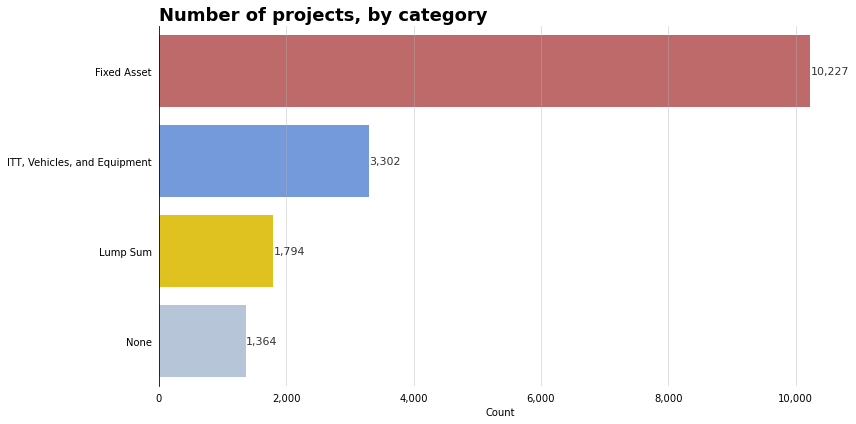

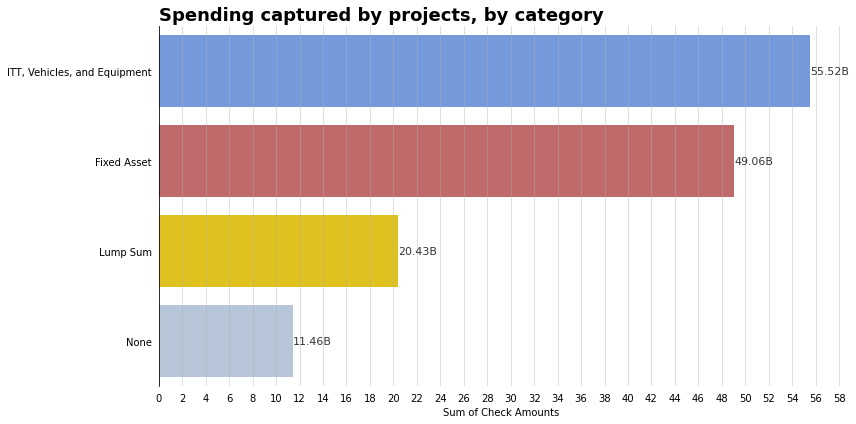

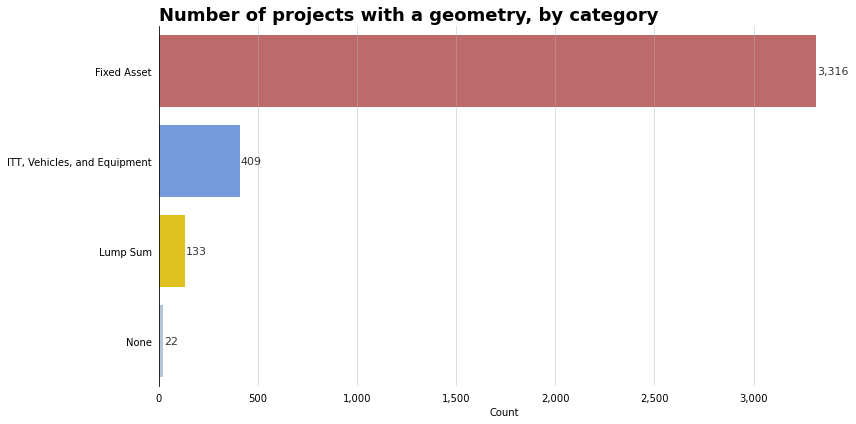

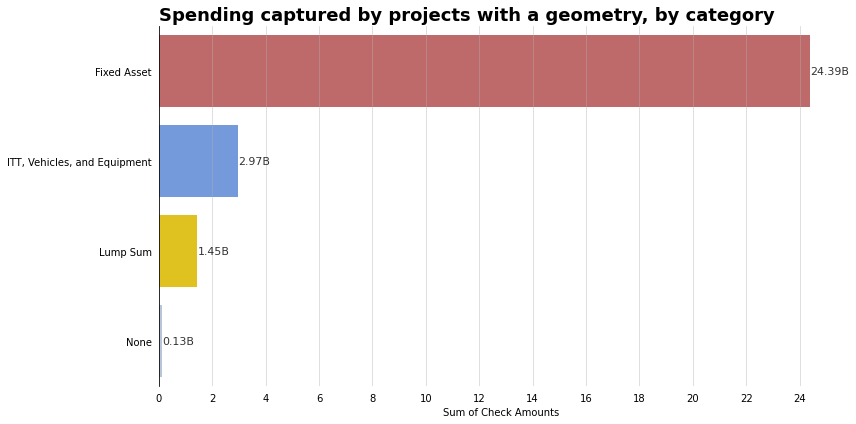

In [33]:
subset = ['all', 'geoms_only']

for s in subset:
    if s == 'all':
        stats_categorized_projects(checkbook_gdf)
    else:
        stats_categorized_projects(checkbook_gdf, True)

In [34]:
# bar_geom_cat_vals = {'Sum of Check Amounts': [cat_check_sum, "Spending captured by projects with a geometry, by category", 'final_viz/spending_projects_with_geoms_by_cat_bar_h.png'],
# 'Count': [cat_counts, 'Number of projects with a geometry, by category', 'final_viz/num_projects_with_geoms_by_cat_bar.png']}

# for k,v in bar_geom_cat_vals.items():
#     horizontal_bar_chart(v[0], v[1], k, 'Category', v[2])

# # horizontal_bar_chart(cat_check_sum, "Spending captured by projects with a geometry, by category", 
# # "Sum of Check Amounts", 'Category', 'final_viz/spending_projects_with_geoms_by_cat_bar_h.png')

### Pie chart

In [35]:
def pie_chart(data, title, goal, path):
    """
    :param data: entire historical liquidations df including rows with/without geometries 
    :type data: pandas DataFrame
    :param title: title of graph to be displayed
    :type title: str
    :param goal: either 'money' or 'num_projects'
    :type goal: str
    :param path: path and filename for saving plot
    :type path: str
    :return: Nothing
    :rtype: None
    """
    fig, ax = plt.subplots(figsize=(6,6))
    geoms = data[data['has_geometry']==True]
    
    n = data.shape[0]
    m = geoms.shape[0]

    if goal == 'money':
        n = sum(geoms['Check Amount'])
        m = sum(data['Check Amount'])
    elif goal == 'num_projects':
        n = geoms.shape[0]
        m = data.shape[0]
    
    data = [(n/m), (1-(n/m))]

    labels = ['Geometries', 'No geometries']
    patches, texts, pcts = ax.pie(data, labels=labels, colors=sns.color_palette('tab20'), autopct='%.2f%%',
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        textprops={'size': 'large'},
        startangle=360,
        explode=(0, 0.1))
    ax.set_title(title,  fontsize = 14, fontweight = 'bold', color = 'black', pad = 10 )
    plt.setp(pcts, color='black', fontweight=400)
    plt.setp(texts, fontweight=600)
    plt.tight_layout()
    plt.show()
    fig.savefig(path, facecolor='white', transparent=False, bbox_inches='tight')
    
    return 

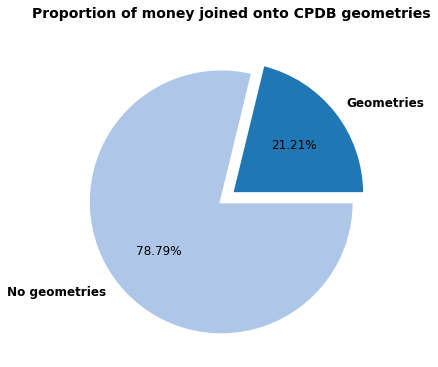

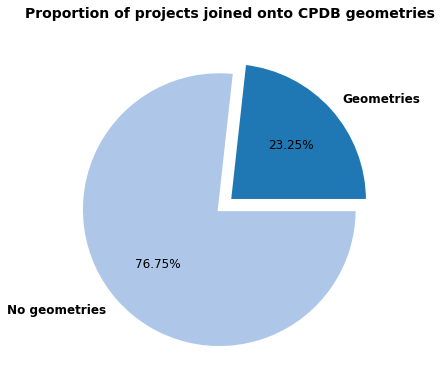

In [36]:
pie_vals = {'money': ['Proportion of money joined onto CPDB geometries', 'final_viz/percent_money_pie.png'],
'num_projects': ['Proportion of projects joined onto CPDB geometries', 'final_viz/percent_projects_pie.png']}

for k, v in pie_vals.items():
    pie_chart(checkbook_gdf, v[0], k, v[1])

## Stacked bar chart

In [37]:
def percent_stacked_bar_chart(data, title, path, goal):
    """
    :param data: dataframe to be charted 
    :type data: pandas DataFrame
    :param title: title of plot 
    :type title: str
    :param x: name of column in data to be plotted on x axis
    :type x: str
    :param y: name of column in data to be plotted on y axis
    :type y: str
    :param path: path and filename for saving plot
    :type path: str
    :param goal: intention of what is to be displayed, either spend or counts
    :type goal: str
    :return: Nothing
    :rtype: None
    """

    ### 
    temp_data = data.set_index(['has_geometry'])

    ### --- data 
    # split into three subsets, rows with geometries, rows without, and all rows
    geoms = data[data['has_geometry']==True]
    no_geoms = data[data['has_geometry']==False]

    # how can I make this less repetitive... 
    if goal == 'spend':
        col = 'Check Amount'
        ylabel = 'Percent of spend'
        total = data.groupby('has_geometry')['Check Amount'].count().reset_index()
        geoms_percent = geoms.groupby('final_category')['Check Amount'].sum() / total.loc[1, col] * 100
        no_geoms_percent = no_geoms.groupby('final_category')['Check Amount'].sum()/ total.loc[0, col] * 100
        all_percent = data.groupby('final_category')['Check Amount'].sum() / data[col].count() * 100
        
    
    elif goal == 'count':
        col = 'FMS ID'
        ylabel = 'Percent of projects'
        total = data.groupby('has_geometry')['FMS ID'].count().reset_index()
        geoms_percent = geoms['final_category'].value_counts() / total.loc[1, col] * 100
        no_geoms_percent = no_geoms['final_category'].value_counts() / total.loc[0, col] * 100
        all_percent = data['final_category'].value_counts() / data[col].count() * 100

    # combine the percentages into a single DataFrame
    percent_data = pd.concat([geoms_percent, no_geoms_percent, all_percent], axis=1)
    percent_data.columns = ['With Geometry', 'Without Geometry', 'All Projects']

    fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
    ax = axs
    percent_data.plot(kind='bar', stacked=True, ax=ax)

    #ax = sns.barplot(data=data, y=y, x=x, ax=ax, palette = data['Color'])

    for container in ax.containers:
        ax.bar_label(container, labels=[f'{int(val)}%' for val in container.get_height()], label_type='edge')

    # tick marks and 0-line
    sns.despine(ax=ax, bottom = True )
    ax.tick_params( left=False, bottom=False )
    ax.set_title(title, fontsize=18, fontweight="bold", loc="left")
    ax.grid(axis='x', linestyle='-', alpha=0.5, zorder = 0 )
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Percent')
    plt.tight_layout( h_pad=1 )

    ## change x-axis ticks and labels
    # if x == 'Sum of Check Amounts':
    #     ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x/1e9):d}"))
    #     ax.xaxis.set_major_locator(ticker.MultipleLocator(base=2e9))
    # elif x == 'Count':
    #     ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))
        
    #fig.savefig(path, facecolor='white', transparent=False, bbox_inches='tight')
    plt.show()
    return

## Random

In [39]:
print(checkbook_gdf['geometry'].nunique())
print(checkbook_geoms_only['geometry'].nunique())
print(checkbook_gdf[checkbook_gdf['geometry'].isnull()].shape)

3272
3272
(12807, 22)


## Project-level summary stats

In [40]:
### summary of project-level checkbook data 

print(df_bc_cp_cats.shape)
print(df_bc_cp_cats.columns)
print(df_bc_cp_cats.describe())

(16687, 7)
Index(['FMS ID', 'Check Amount', 'Contract Purpose', 'Budget Code', 'Agency',
       'bc_category', 'cp_category'],
      dtype='object')
       Check Amount
count  1.668700e+04
mean   8.177877e+06
std    1.708175e+08
min    0.000000e+00
25%    9.924918e+04
50%    4.307605e+05
75%    2.195817e+06
max    2.095610e+10


In [44]:
print(sum(checkbook_gdf['Check Amount']))


136464231215.37947


In [46]:
max_row = df_bc_cp_cats[df_bc_cp_cats['Check Amount']>20956100000]
print(max_row['Budget Code']))
max_row_agencies = max_row['Agency']

176    CS07 (KIPP CHARTER HIGH SCHOOL - BRONX);CS08 (...
Name: Budget Code, dtype: object
176    SCHOOL CONSTRUCTION AUTHORITY;SCHOOL CONSTRUCT...
Name: Agency, dtype: object
